# Zillow Zestimates in 2017

by Mathias Boissevain 2022-04-08

## Project Goal

The goal of this project is to understand the drivers of error in Zillow's Zestimates for single family homes sold in 2017.

## Project Description

Here at Zillow we pride ourselves in providing acurrate data to our customer base. To keep an edge in this highly competitive online space, we must strive for consistant improvement. In this project I will explore what features we can use to improve our current models that predict Zestimate scores of Single Family Properties that had a transaction in 2017 by understanding the drivers of logerror.

## Initial Questions

- Is Logerror affected by Location?
- Is Logerror affected by the house attributes?
- Is Logerror affected by the age of the property?
- Is logerror affected by the time of year it is sold?
- Is logerror affected by the tax values?

## Data Dictionary

Variable | Meaning |
:-: | :-- |
'bathrooms'	| Number of bathrooms in home including fractional bathrooms
'bedrooms'	| Number of bedrooms in home 
'area'	| Calculated total finished living area of the home 
'latitude'	| Latitude of the middle of the parcel multiplied by 10e6
'longitude'	| Longitude of the middle of the parcel multiplied by 10e6
'lot_size'	| Area of the lot in square feet
'parcelid'	| Unique identifier for parcels (lots) 
'city'	| City in which the property is located (if any)
'zip'	| Zip code in which the property is located
'yearbuilt'	| The Year the principal residence was built 
'taxable_value'	| The total tax assessed value of the parcel
'taxamount'	| The total property tax assessed for that assessment year
'month_sold' | The month the property was sold
'age' | The age of the property
'long_use' |  Type of land use the property is zoned for

## Wrangle Zillow Data

The Codeup mySQL server was used to retrieve the zillow dataset using the following query:

In [2]:
# Import wrangle module for acquistion and processing
import wrangle

# Import warning to stop unneeded warning messages
import warnings
warnings.filterwarnings('ignore')

The data was prepared in the following steps:

1) Columns were dropped for lack of data and redundancy

2) New features were created. 

    - age == 2017 - year_built
    - month_sold == bedrooms / bathrooms


3) Columns were renamed for ease of use and clarity

4) land_use types were renamed for ease of use

5) properties were filtered by land use type and unit count

6) Missing values were dropped first by dropping rows and columns with more than 50% missing then by individual values.

7) Dummy variables were created for land_use variables and then added to the dataframe

7) Outliers were removed

8) The data was then split for modeling

In [4]:
# Acquire and Prepare data
train, validate, test = wrangle.wrangle_zillow(wrangle.acquire_zillow())

Using CSV


Our data is split into 3 samples:

- The train sample represents 56 % of the data and is used to train the model
- The validate sample represents 24 % of the data and is used to test for overfitting
- The test sample reresents 20 % of the data and is used to test our top model
- All splits were done with a seed of 1729

In [5]:
# Assign X for testing the model, y as target for modeling

X_train, y_train = wrangle.model_split(train)
X_validate, y_validate = wrangle.model_split(validate)
X_test, y_test = wrangle.model_split(test)

Our train, validate and test sets were further split into:
- X: Data used for modeling that does not contain the target variable
- y: The target variable that our models will be trained to predict

In [7]:
# Scale the appropriate values for train, validate and test

X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.scale_data(X_train,X_validate,X_test)

## Data Context

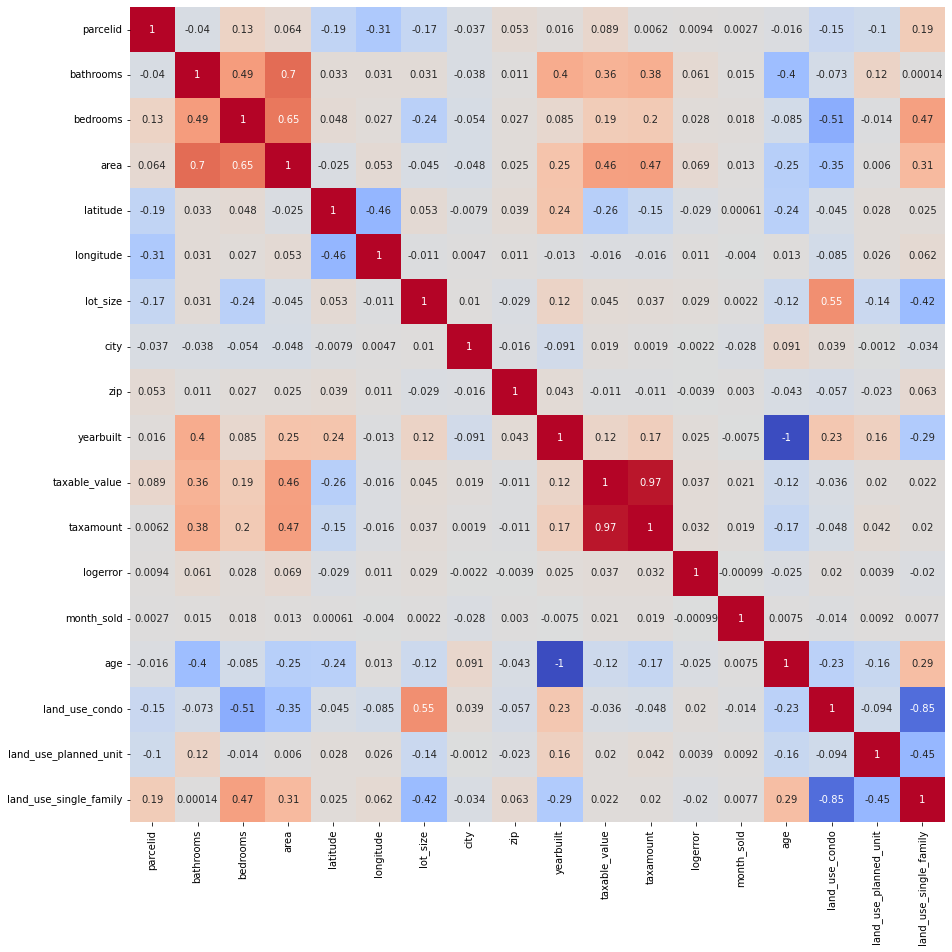

In [68]:
# Import for visualizations
from matplotlib import pyplot as plt
import seaborn as sns

# Perform a Pearson Correlation on the dataset
plt.figure(figsize=(15,15))
correlate = train.corr()
sns.heatmap(correlate, annot=True, cmap='coolwarm',square=True,cbar=False)
plt.show()

## Exploratory Data Analysis

### Is Logerror affected by location?

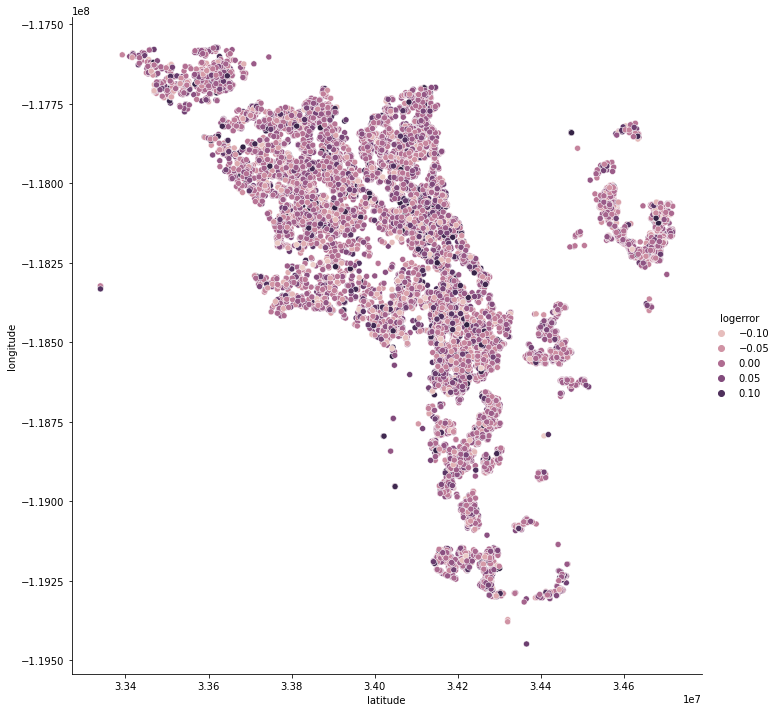

In [10]:
# Plot the latitude and longitude with logerror as the Hue
sns.relplot(x='latitude',y='longitude',data=train, hue='logerror',height=10)
plt.show()

**Summary:** Logerror seemed to be different through out the area.

### Is Logerror affected by the house attributes?

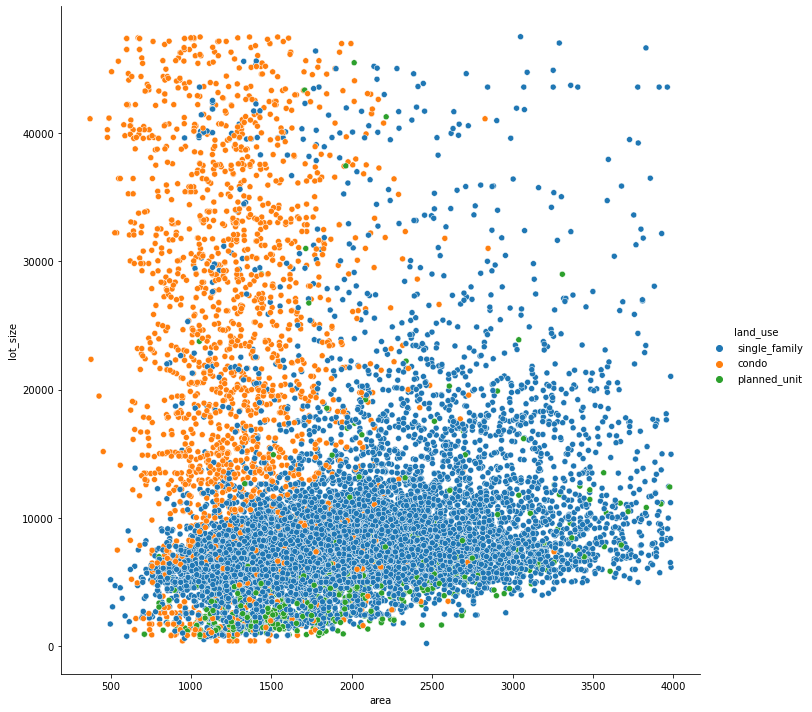

In [11]:
# Plot the area and lot_size with the land_use as the hue
sns.relplot(x='area', y='lot_size', data=train, hue= 'land_use', height=10)
plt.show()

**ANOVA Hypothesis Test**
- $H_0$: population means of the logerror for the land use types are all equal
- $H_α$: population means of the logerror for the land use types are not all equal

In [82]:
# Import stats for hypothesis testing
import scipy.stats as stats

# Seperate land use types
sf = train[train.land_use == 'single_family'].logerror
co = train[train.land_use == 'condo'].logerror
pu = train[train.land_use == 'planned_unit'].logerror

# run the ANOVA test
f, p = stats.f_oneway(sf,co,pu)

print('ANOVA results:\n')
if p < 0.05:
    print('Reject the Null')
else:
    print('Fail to reject the Null')

ANOVA results:

Reject the Null


**Summary:** When comparing Land use types to the differences in lot_size and house area there looked to be different groupings worth further exploration. According to the ANOVA test the the logerror means of each land use type are different.

### Is Logerror affected by the age of the property?

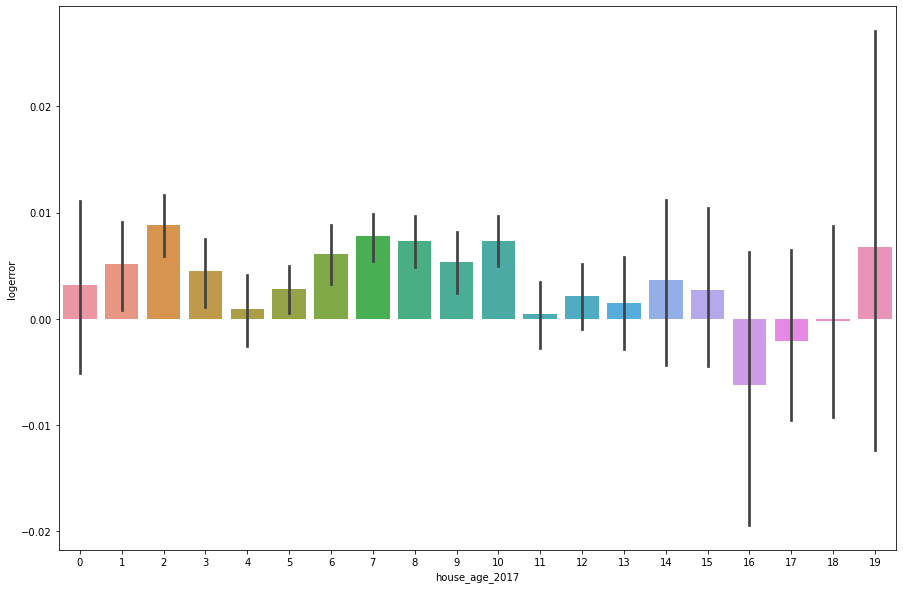

In [50]:
# import pandas for binning data
import pandas as pd
# Make copy to bin
train_age = train.copy()
# Bin data
train_age['house_age_2017'] = pd.cut(train_age.age, 20,labels=False)
# setup subplots
fig, ax = plt.subplots(ncols=1,figsize=(15,10))
# barplot
sns.barplot(x='house_age_2017', y='logerror', data=train_age)
plt.show()

**Summary:** There does seem to be some trend with log error over time. Worth further exploration.

### Is Logerror affected by the time of year it was sold?

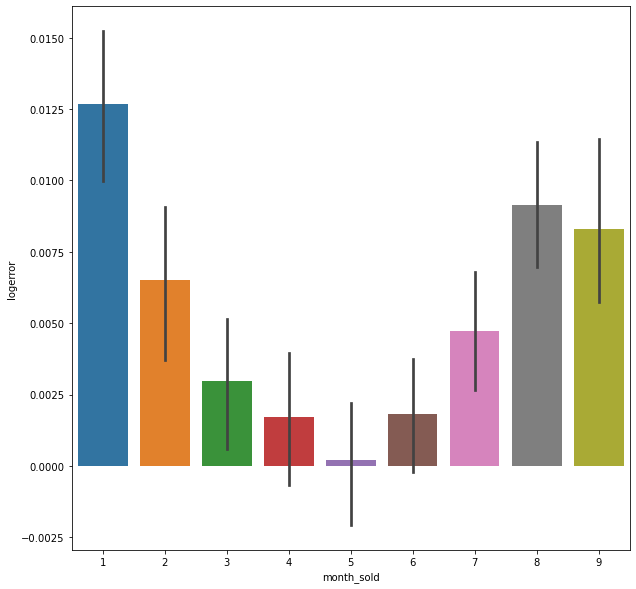

In [48]:
# Set size of figure
plt.figure(figsize=(10,10))
# Barplot with month sold and logerror
sns.barplot(x='month_sold', y='logerror', data=train_age)
plt.show()

**Pearson R Hypothesis Test**
- $H_0$: There is no linear correlation between the month sold and the logerror
- $H_α$: There is a linear correlation between the month sold and the logerror

In [86]:
# Run Correlation test
corr, p = stats.pearsonr(train.month_sold,train.logerror)

# Print test name
print('Pearson R Test:')

# Assess p Value
if p < 0.05:
    print('Reject Null Hypothesis')
else: 
    print('Do not reject Null Hypothesis')

Pearson R Test:
Do not reject Null Hypothesis


Summary: It does look as logerror has varies less in the summer months. 

### Is logerror affected by the tax values?

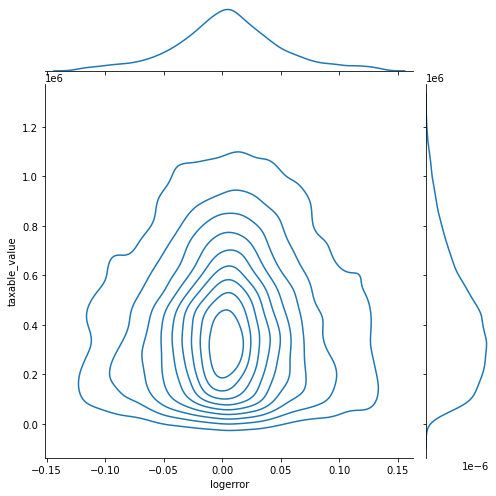

In [54]:
# Jointplot with logerror vs taxable_value
sns.jointplot(x='logerror', y='taxable_value', data=train, kind='kde',height=7)
plt.show()

Summary: There looks to be a slight trend of variation in logerror getting smaller as the taxable value rises. This could also be because less houses were sold at the higher value range. Further analysis is necessary.

## Clustering 

### Kmeans of House Attributes (area, lot_size, land_use)

In [18]:
# Import for clustering
from sklearn.cluster import KMeans

# Assign target variables to cluster
X = X_train[['area','lot_size','land_use_condo','land_use_planned_unit',\
                  'land_use_single_family']]

# Create the model
kmeans = KMeans(n_clusters=3,random_state=1729)

# Fit the model
kmeans.fit(X)

# Pridict on Training data
kmeans.predict(X)

# Assign to train and train_scaled
X_train['cluster'] = kmeans.predict(X)
X_train_scaled['cluster'] = kmeans.predict(X)

#### Inertia:

Text(0.5, 1.0, 'Change in inertia as k increases')

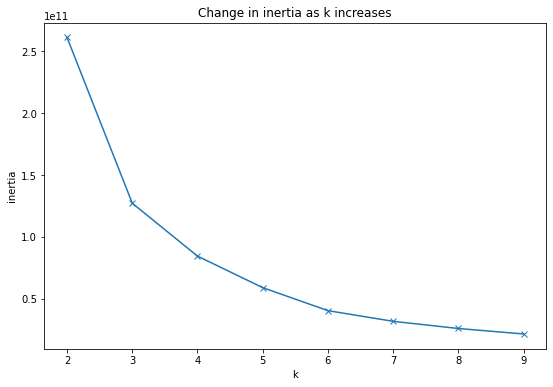

In [70]:
# Set figure size
plt.figure(figsize=(9, 6))

# Create Series to plot
pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 10)}).plot(marker='x')

# Set ticks
plt.xticks(range(2, 10))

# Label Data
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

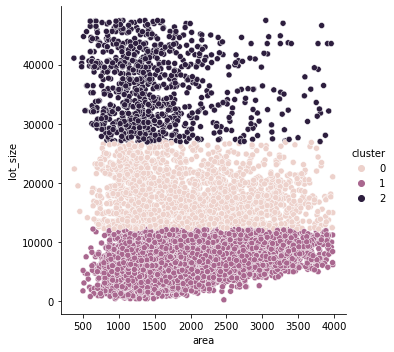

In [56]:
sns.relplot(x='area', y='lot_size', data=X_train, hue= 'cluster')
plt.show()

- Clustering on lot_size, area, and land_use gave us 3 cluster

### Kmeans of location (latitude, longitude)

In [25]:
# Assign variable to cluster
X2_train = X_train_scaled[['latitude','longitude']]
X2_validate = X_validate_scaled[['latitude','longitude']]
X2_test = X_test_scaled[['latitude','longitude']]

# Create model
kmeans2 = KMeans(n_clusters=4,random_state=1729)

# Fit, predict, and assign cluster for train
kmeans2.fit(X2_train)
kmeans2.predict(X2_train)
X_train['cluster2'] = kmeans2.predict(X2_train)
X_train_scaled['cluster2'] = kmeans2.predict(X2_train)

# Predict, and assign cluster for validate
kmeans2.predict(X2_validate)
X_validate_scaled['cluster2'] = kmeans2.predict(X2_validate)

# Predict, and assign cluster for test
kmeans2.predict(X2_test)
X_test_scaled['cluster2'] = kmeans2.predict(X2_test)

#### Inertia:

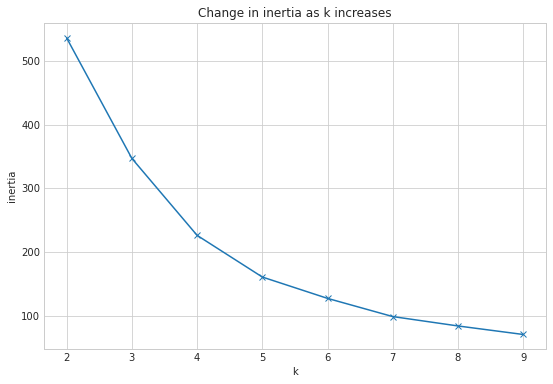

In [27]:
# Set figure size
plt.figure(figsize=(9, 6))

# Create series to plot
pd.Series({k: KMeans(k).fit(X2_train).inertia_ for k in range(2, 10)}).plot(marker='x')

# Assign ticks
plt.xticks(range(2, 10))

# Assign labels
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

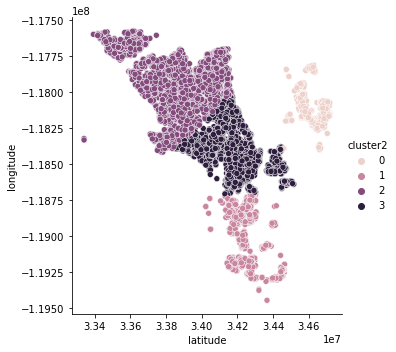

In [58]:
sns.relplot(x='latitude', y='longitude', data=X_train, hue= 'cluster2')
plt.show()

- Clustering on latitude and longitude gave us 4 clusters

### Kmeans of Age and Location (age, latitude, longitude)

In [29]:
# Assign variables to cluster
X3 = X_train[['latitude','longitude','age']]

# Create model
kmeans3 = KMeans(n_clusters=3,random_state=1729)

# Fit and predict on train
kmeans3.fit(X3)
kmeans3.predict(X3)

# Assign clusters to dataset
X_train['cluster3'] = kmeans3.predict(X3)
X_train_scaled['cluster3'] = kmeans3.predict(X3)

#### Inertia

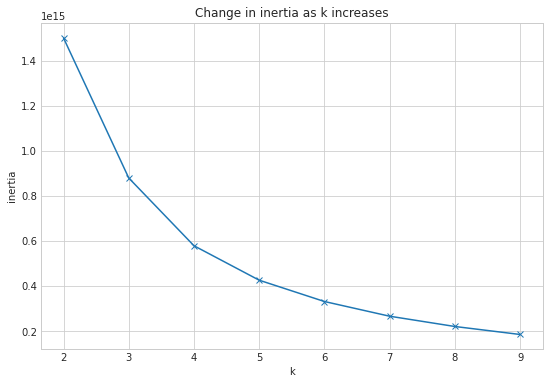

In [31]:
# Set figure size
plt.figure(figsize=(9, 6))

# Assign series to plot
pd.Series({k: KMeans(k).fit(X3).inertia_ for k in range(2, 10)}).plot(marker='x')

# Assign ticks
plt.xticks(range(2, 10))

# Assign labels
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

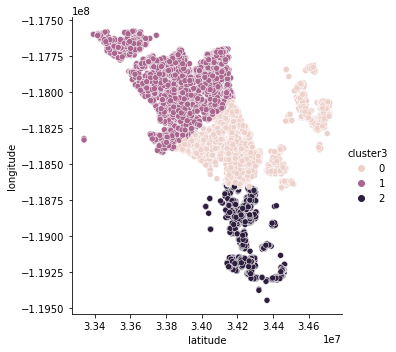

In [60]:
sns.relplot(x='latitude', y='longitude', data=X_train, hue= 'cluster3')
plt.show()

- Clustering on latitude, longitude and age gave us 3 clusters

## SelectKBest

In [32]:
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# We use SelectKBest to run a f_regression stats test and return the top 5
f_selector = SelectKBest(f_regression, k=5)

# We fit this to our data
f_selector.fit(X_train_scaled, y_train)

# Create a boolean mask to find out which were selected
feature_mask = f_selector.get_support()

# We get a list of the top 5 features by name
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature

['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']

**Explore Summary:** Through exploration location alone did not seem to be a big indicator, age did show a difference in logerror over time that is worth further investigation. Properties sold during the summer showed smaller logerror, another point to investigate. Tax value seemed less useful in exploration but according to the SelectKBest function it showed promise along with the latitude/longitude cluster. 

## Modeling

Features: The models that ran the best used the features from the SelectKBest ran above, showing the strongest statistical relationships to logerror.

### Baseline

In [43]:
# Import models
from sklearn.linear_model import LinearRegression, LassoLars,TweedieRegressor 
from sklearn.preprocessing import PolynomialFeatures

# Import for model evaluation
from sklearn.metrics import mean_squared_error

In [69]:
# Predict logerror_pred_mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE Baseline using Mean\nTrain(In-Sample): ", round(rmse_train, 9), 
      "\nValidate(Out-of-Sample): ", round(rmse_validate, 9))

# RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain(In-Sample): ", round(rmse_train, 9), 
      "\nValidate(Out-of-Sample): ", round(rmse_validate, 9))

RMSE Baseline using Mean
Train(In-Sample):  0.04535935 
Validate(Out-of-Sample):  0.044424734
RMSE using Median
Train(In-Sample):  0.045361237 
Validate(Out-of-Sample):  0.044432709


Summary: Mean was chosen as a baseline as it performed slightly bettewr than the median.

## Evaluation Metric

- Root Mean Squared Error was used as the evaluation meteric for this project. This gives us our difference in logerror from our logerror prediction which helps us understand how far off our models are.

## Models

- Four different Alogrithms were chosen as our top performers.

### Linear Regression

In [36]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model
lm.fit(X_train_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']], y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']])

# evaluate: rmse_train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']])

# evaluate: rmse_validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for Ordinary Least Squares using LinearRegression\nTraining(In-Sample): ", rmse_train, 
      "\nValidation(Out-of-Sample): ", rmse_validate)

RMSE for Ordinary Least Squares using LinearRegression
Training(In-Sample):  0.04520292229676917 
Validation(Out-of-Sample):  0.044349742910806636


- The Linear regression model performed just slightly better than the baseline.

### Lasso Lars

In [37]:
# create the model object 
lars = LassoLars(alpha=1.0)

# fit the model 
lars.fit(X_train_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']], y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']])

# evaluate: rmse_train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']])

# evaluate: rmse_validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining(In-Sample): ", rmse_train, 
      "\nValidation(Out-of-Sample): ", rmse_validate)

RMSE for Lasso + Lars
Training(In-Sample):  0.045359349885810224 
Validation(Out-of-Sample):  0.04442473394848872


- The Lasso lars model performed very close to baseline.

### TWeedie Regressor

In [44]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0) 

# fit the model
glm.fit(X_train_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']], y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']])

# evaluate: rmse_train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']])

# evaluate: rmse_validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie\nTraining(In-Sample): ", rmse_train, 
      "\nValidation(Out-of-Sample): ", rmse_validate)

RMSE for GLM using Tweedie
Training(In-Sample):  0.0452193694524779 
Validation(Out-of-Sample):  0.044345432691404264


- The Tweedie Regressor model performed just below baseline

### Polynomial Regression

In [77]:
# make the polynomial features 
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']])

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']])
X_test_degree2 = pf.transform(X_test_scaled[['bathrooms', 'area', 'taxable_value', 'taxamount', 'cluster2']])

In [78]:
# create the model
plm = LinearRegression(normalize=True)

# fit the model
plm.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_plm'] = plm.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_plm)**(1/2)

# predict validate
y_validate['logerror_pred_plm'] = plm.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_plm)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining(In-Sample): ", rmse_train, 
      "\nValidation(Out-of-Sample): ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training(In-Sample):  0.04514525362234098 
Validation(Out-of-Sample):  0.044304223567275716


- The Polynomial Regression performed very close to baseline but did just slightly better than the rest so it is our top performer.

### Zillow's next top model

In [46]:
y_test_scaled = pd.DataFrame(y_test)

# predict on test
y_test['logerror_pred_plm'] = plm.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_plm)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest(Out-of-Sample): ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test(Out-of-Sample):  0.04339596207064994


- The Polynomial Regression model ran the best and performed the best on test data with a RMSE of 0.0433959 compared to baseline train: 0.04535935 and baseline validate: 0.044424734. 

## Conclusion

#### Summary

- In exploration size of the living space and month sold showed promise for being indicators of legerror.

- In the modeling phase the SelectKBest choices showed the best results with the cluster for lat/long being used along with taxable_value, tax_amount, area and bathrooms used.

### Recommendations

- Moving forward more should be done to ensure the we are able to gather more data to get a better view of the properties being analyzed. 

### Next Steps

- Given more time possible feature engineering can be done by looking at features such as age of home and month sold, as well as understand the differences in location and how they relate. A better assesment should be done to understand missing data and outliers. 